# Pattern classifier neural network

In [200]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image

## Model structure

### Activation functions

In [201]:
def softmax(z: npt.NDArray) -> npt.NDArray:
    z = np.array(z)
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)


def relu(z: npt.NDArray) -> npt.NDArray:
    return np.maximum(0, z)


def relu_derivative(z: npt.NDArray) -> npt.NDArray:
    return (z > 0).astype(float)

### Loss function

In [202]:
def cross_entropy(y_pred: npt.NDArray, y_target: npt.NDArray) -> float:
    return -np.sum(y_target * np.log(y_pred + 1e-15))

### Layer

In [203]:
class Layer:
    def __init__(self, input_dim: int, units: int, activation, activation_deriv):
        self.activation = activation
        self.activation_deriv = activation_deriv
        # self.W = np.random.rand(units, input_dim) * 0.1
        #self.W = np.random.randn(units, input_dim) * np.sqrt(2. / input_dim)
        self.W = np.random.normal(0, np.sqrt(2. / input_dim), (units, input_dim))
        self.b = np.zeros((units, 1))

    def forward(self, x: npt.NDArray) -> npt.NDArray:
        self.x = x
        self.z = self.W @ x + self.b
        self.a = self.activation(self.z)

        return self.a

    def backward(self, grad_output: npt.NDArray, learning_rate: float) -> npt.NDArray:
        dz = grad_output * self.activation_deriv(self.z)
        dW = dz @ self.x.T
        db = dz
        dx = self.W.T @ dz
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx


### Neural Network

In [204]:
class NeuralNetwork:

    def __init__(self, layers: list[Layer]):
        self.layers = layers

    def forward(self, x: npt.NDArray) -> npt.NDArray:
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, grad_output: npt.NDArray, learning_rate: float) -> None:
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)

    def train(
            self,
            x_train: npt.NDArray,
            y_train: npt.NDArray,
            x_val: npt.NDArray,
            y_val: npt.NDArray,
            epochs: int,
            learning_rate: float) -> tuple[list[float], list[float]]:
        train_losses: list[float] = []
        val_losses: list[float] = []
        best_val_loss = float('inf')
        patience = 30
        min_delta = 0.00001
        patience_counter = 0
        best_weights = None

        for epoch in range(epochs):
            train_loss: float = 0.0
            for x, y in zip(x_train, y_train):
                # Reshaping to column vector.
                x: npt.NDArray = x.reshape(-1, 1)
                y: npt.NDArray = y.reshape(-1, 1)
                # Forward pass
                output = self.forward(x)
                # Loss
                train_loss += cross_entropy(output, y)
                # Backpropagation
                grad_output = output - y
                self.backward(grad_output, learning_rate)

            train_losses.append(float(train_loss) / len(y_train))

            val_loss = 0.0
            for x, y in zip(x_val, y_val):
                # Reshaping to column vector.
                x: npt.NDArray = x.reshape(-1, 1)
                y: npt.NDArray = y.reshape(-1, 1)

                output = self.forward(x)
                val_loss += cross_entropy(output, y)

            val_loss /= len(y_val)
            val_losses.append(float(val_loss))

            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                patience_counter = 0
                best_weights = [(layer.W.copy(), layer.b.copy()) for layer in self.layers]
            else:
                patience_counter += 1

            if epoch % 100 == 0 or epoch + 1 == epochs:
                print(f"Epoch {epoch}: train_loss = {train_losses[-1]:.5f}, val_loss = {val_losses[-1]:.5f}")

            if patience_counter >= patience:
                print(f'Early stopping at {epoch} epoch')
                break

        if best_weights:
            for layer, (W, b) in zip(self.layers, best_weights):
                layer.W = W
                layer.b = b

        return train_losses, val_losses

    def predict(self, x: npt.NDArray) -> npt.NDArray:
        x = x.reshape(-1, 1)
        output = self.forward(x)
        return output

## Training

In [205]:
import os

class_names = ['uniform', 'horizontal', 'vertical', 'diagonal']
class_index = {name: i for i, name in enumerate(class_names)}


def load_dataset(folder_path: str) -> tuple[npt.NDArray, npt.NDArray]:
    X, y = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpeg'):
            path = os.path.join(folder_path, filename)
            class_name = filename.split('_')[0]
            img = Image.open(path)
            normalized_img = np.asarray(img, dtype=np.float32) / 255.0
            X.append(normalized_img.flatten())
            y.append(np.eye(len(class_names))[class_index[class_name]])

    return np.array(X), np.array(y)

In [206]:
X, y = load_dataset('./dataset')

test_ratio = 0.2
val_ratio = 0.1
num_samples = X.shape[0]

num_val = int(num_samples * val_ratio)
num_test = int(num_samples * test_ratio)

indices = np.random.permutation(num_samples)

val_idx = indices[:num_val]
test_idx = indices[num_val:num_val + num_test]
train_idx = indices[num_val + num_test:]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

Epoch 0: train_loss = 0.77893, val_loss = 0.39170
Epoch 100: train_loss = 0.00196, val_loss = 0.00263
Early stopping at 161 epoch


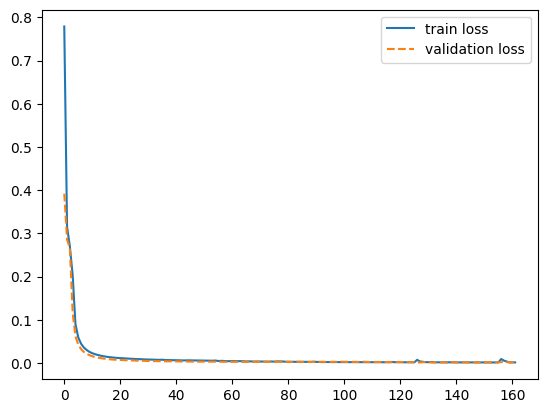

In [207]:
layers = [
    Layer(4, 6, relu, relu_derivative),
    Layer(6, 6, relu, relu_derivative),
    Layer(6, 4, softmax, lambda x: 1)
]

nn = NeuralNetwork(layers)
train_loss, val_loss = nn.train(X_train, y_train, X_val, y_val, 1000, 0.01)


In [ ]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss', linestyle='--')
plt.legend()
plt.show()

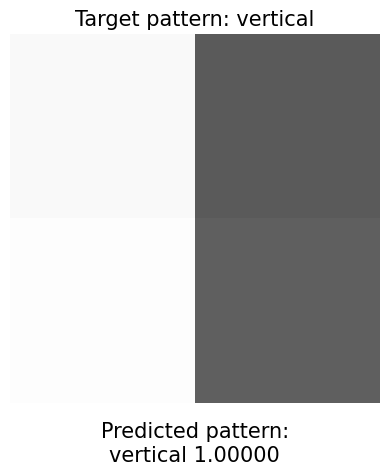

In [208]:
rand_sample = np.random.randint(0, X_test.shape[0])
sample_class = class_names[np.argmax(y_test[rand_sample])]
sample_img = Image.fromarray(X_test[rand_sample].reshape((2, 2)) * 255.0)

output = nn.predict(X_test[rand_sample])
pred_class = class_names[np.argmax(output)]
confidence = output[np.argmax(output)].item()

plt.imshow(sample_img, cmap='grey', vmin=0, vmax=255)
plt.title(f'Target pattern: {sample_class}', fontsize=15)
plt.text(0.5, 1.6, f'Predicted pattern:\n{pred_class} {confidence:.5f}', fontsize=15, ha='center', va='top')
plt.axis('off')
plt.show()

## Evaluation Metrics

In [209]:
def accuracy(model: NeuralNetwork, X: npt.NDArray, y: npt.NDArray) -> float:
    correct: int = 0
    total = X.shape[0]

    for x, target in zip(X, y):
        output = model.predict(x)
        predicted_class = np.argmax(output)
        target_class = np.argmax(target)
        if predicted_class == target_class:
            correct += 1

    return correct / total


print(f'Accuracy: {accuracy(nn, X_test, y_test)}')

Accuracy: 1.0


In [210]:
def precision(model: NeuralNetwork, X: npt.NDArray, y: npt.NDArray, n_classes: int) -> list[float]:
    tp = np.zeros(n_classes)
    tf = np.zeros(n_classes)

    for x, target in zip(X, y):
        output = model.predict(x)
        y_pred = np.argmax(output)
        y_target = np.argmax(target)

        if y_pred == y_target:
            tp[y_pred] += 1
        else:
            tf[y_pred] += 1

    precision: list[float] = []

    for i in range(n_classes):
        if tp[i] + tf[i] == 0:
            precision.append(0.0)
        else:
            precision.append(float(tp[i] / (tp[i] + tf[i])))

    return precision


print(f'Precision: {precision(nn, X_test, y_test, 4)}')

Precision: [1.0, 1.0, 1.0, 1.0]


### Confusion matrix

In [211]:
def confusion_matrix(model: NeuralNetwork, X: npt.NDArray, y: npt.NDArray, n_classes: int) -> npt.NDArray:
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)

    for x, target in zip(X, y):
        output = model.predict(x)
        y_pred = np.argmax(output)
        y_target = np.argmax(target)

        conf_matrix[y_target][y_pred] += 1

    return conf_matrix


cm = confusion_matrix(nn, X_test, y_test, 4)

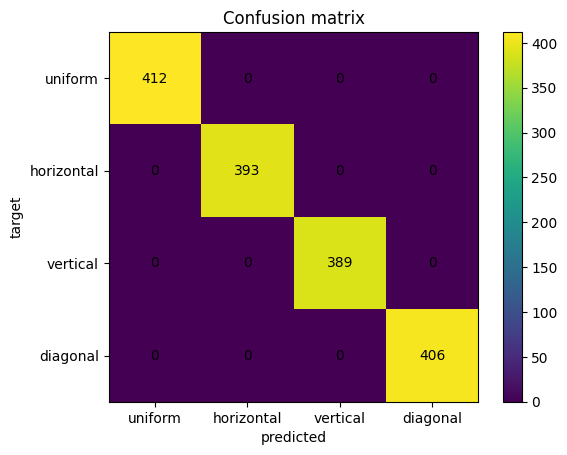

In [212]:
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='viridis')

ax.set_xticks(range(len(class_names)), labels=class_names)
ax.set_yticks(range(len(class_names)), labels=class_names)

for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

ax.set_title('Confusion matrix')
ax.set_xlabel('predicted')
ax.set_ylabel('target')
fig.colorbar(im)
plt.show()